# ADS 505
Jose Guarneros Padilla, Nolan Peters, Tysir Shehadey

In [ ]:
pip install ucimlrepo

In [ ]:
pip install jupyter_black

In [ ]:
pip install shap

### Packages we will be using

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

%load_ext jupyter_black

In [ ]:
# fetch dataset
online_news_popularity = fetch_ucirepo(id=332)

# data (as pandas dataframes)
X = online_news_popularity.data.features
y = online_news_popularity.data.targets

In [ ]:
X.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364


In [ ]:
y.head()

,shares
0,593
1,711
2,1500
3,1200
4,505


# Preprocessing

In [ ]:
# Strip any leading/trailing spaces from all column names
X.columns = X.columns.str.strip()

In [ ]:
y.columns = y.columns.str.strip()

In [ ]:
# create single dataframe for visuals
df_main = pd.concat([X, y], axis = 1)

In [ ]:
# Check for missing values in the features
missing_values_X = X.isnull().sum()

print(missing_values_X)

n_tokens_title                   0
n_tokens_content                 0
n_unique_tokens                  0
n_non_stop_words                 0
n_non_stop_unique_tokens         0
num_hrefs                        0
num_self_hrefs                   0
num_imgs                         0
num_videos                       0
average_token_length             0
num_keywords                     0
data_channel_is_lifestyle        0
data_channel_is_entertainment    0
data_channel_is_bus              0
data_channel_is_socmed           0
data_channel_is_tech             0
data_channel_is_world            0
kw_min_min                       0
kw_max_min                       0
kw_avg_min                       0
kw_min_max                       0
kw_max_max                       0
kw_avg_max                       0
kw_min_avg                       0
kw_max_avg                       0
kw_avg_avg                       0
self_reference_min_shares        0
self_reference_max_shares        0
self_reference_avg_s

In [ ]:
# Check for missing values in the target variable
missing_values_y = y.isnull().sum()

print(missing_values_y)

shares    0
dtype: int64


# Exploratory Data Analysis

First we will analyze correlations between continuous variables.

In [ ]:
def polt_dist(df, col, lim=None):
    plt.figure(figsize=(4, 4))
    sns.boxplot(df[col])
    plt.ylim(lim)
    plt.show()

In [ ]:
df_meta = df_main.iloc[:,:11]
df_kw = df_main.iloc[:,17:29]
df_pol = df_main.iloc[:,37:58]

In [ ]:
df_col = pd.concat([df_meta, df_kw, df_pol], axis = 1)
df_col['shares'] = df_main['shares']

### Removing outliers

In [ ]:
# remove related variables / keep avg or base level of engineered variables
drop_var_pair = [
    "n_non_stop_unique_tokens",
    "num_self_hrefs",
    "kw_min_min",  # keep average shares from average kw
    "kw_max_min",
    "kw_min_max",
    "kw_max_max",
    "kw_min_avg",
    "kw_max_avg",
    "self_reference_min_shares",
    "self_reference_max_shares",
    "global_rate_positive_words",
    "global_rate_negative_words",
    "rate_positive_words",
    "rate_negative_words",
    "min_positive_polarity",
    "max_positive_polarity",
    "min_negative_polarity",
    "max_negative_polarity",
    "title_subjectivity",
    "title_sentiment_polarity",
    "weekday_is_monday",
    "weekday_is_tuesday",
    "weekday_is_wednesday",
    "weekday_is_thursday",
    "weekday_is_friday",
    "weekday_is_saturday",
    "weekday_is_sunday",
]

df_main_pair = df_main.drop(drop_var_pair, axis=1)

# define plot function
def polt_dist(df, col, lim=None):
    plt.figure(figsize=(4, 4))
    sns.boxplot(df[col])
    plt.title(f"{col} distribution")
    plt.ylim(lim)
    plt.show()

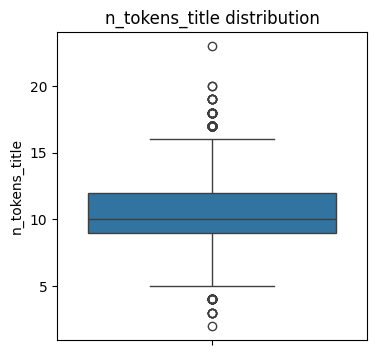

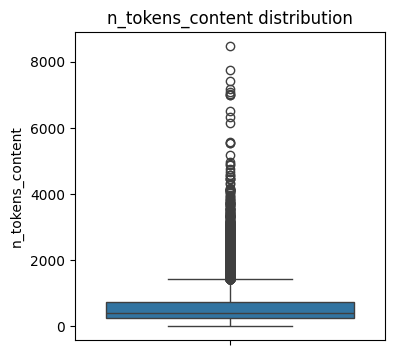

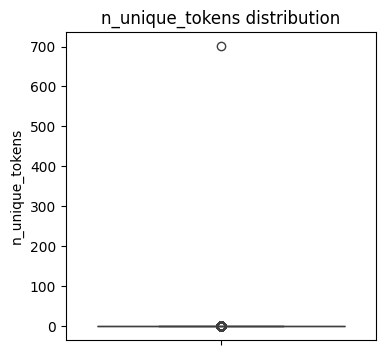

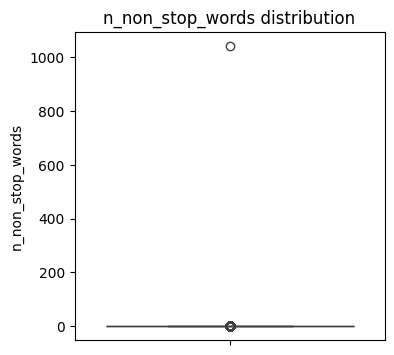

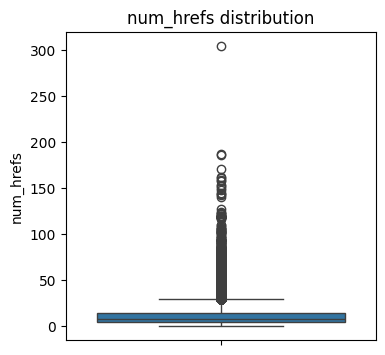

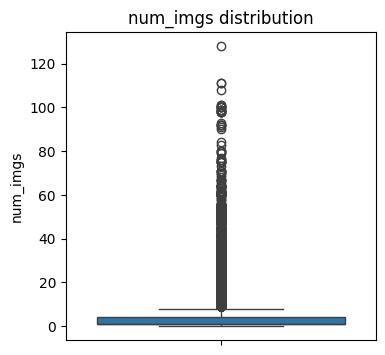

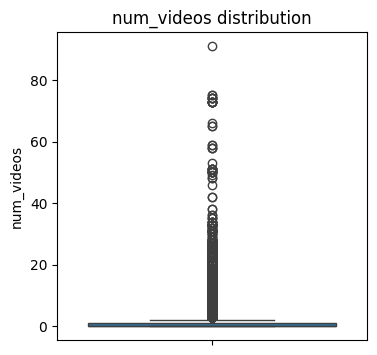

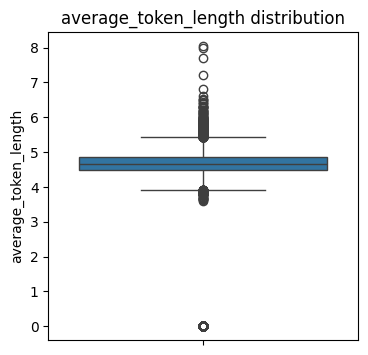

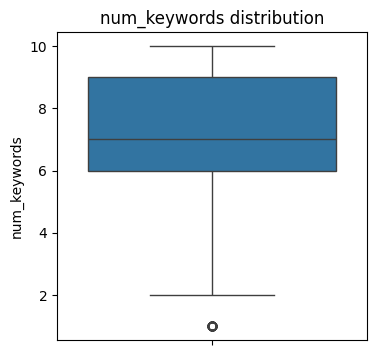

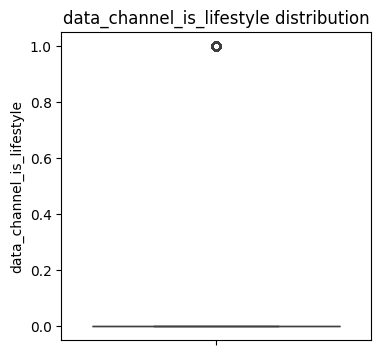

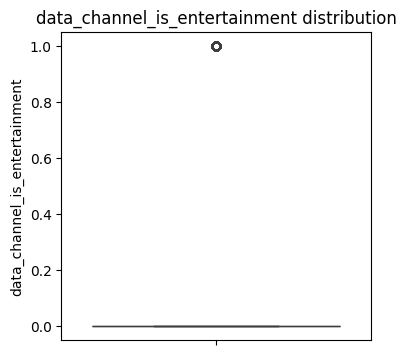

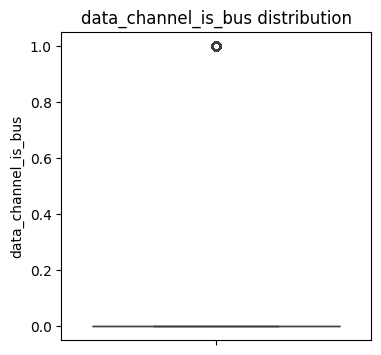

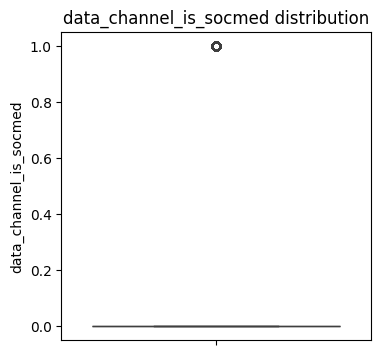

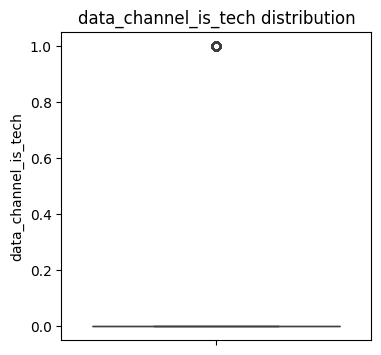

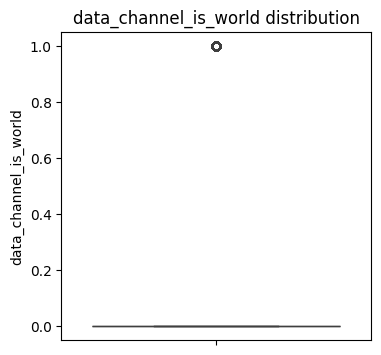

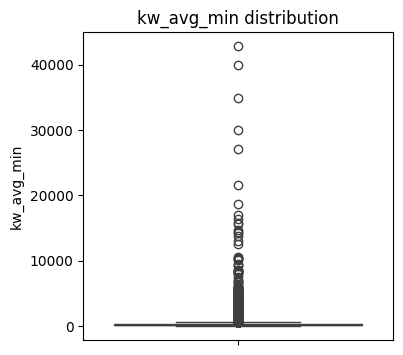

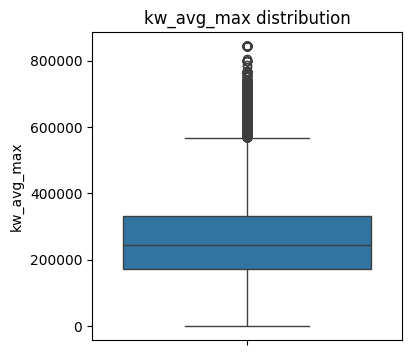

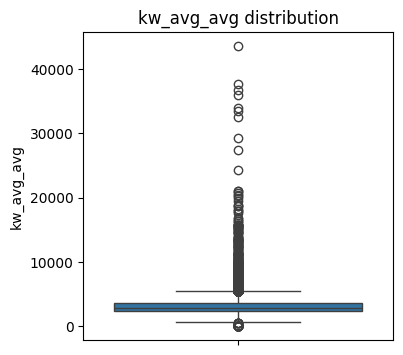

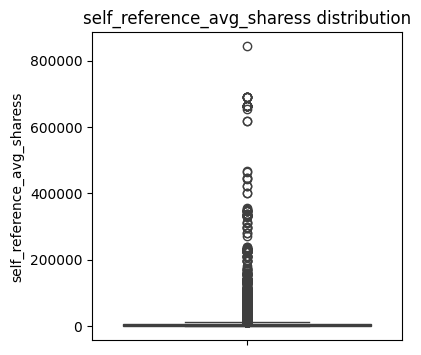

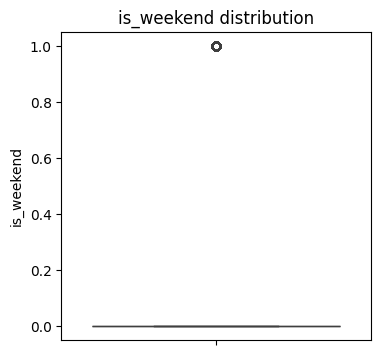

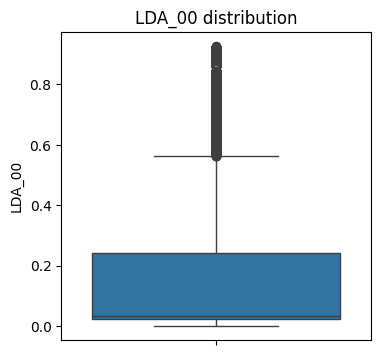

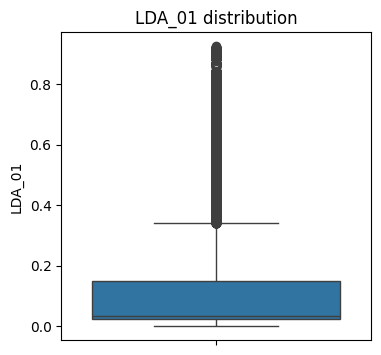

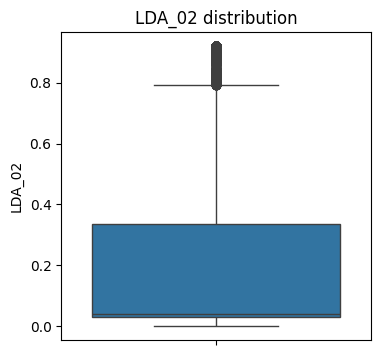

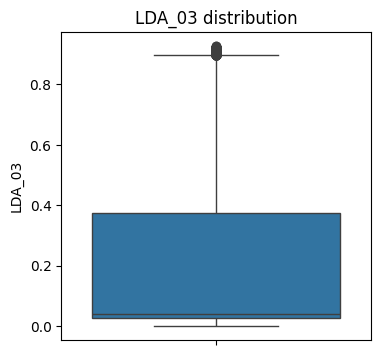

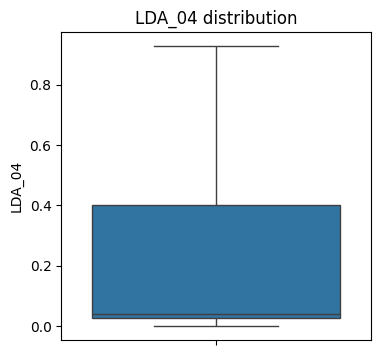

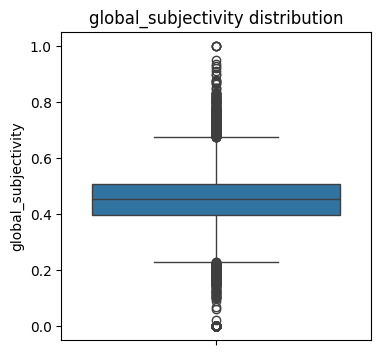

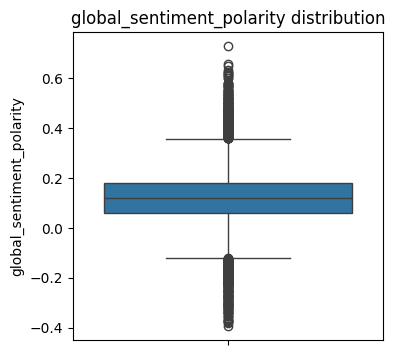

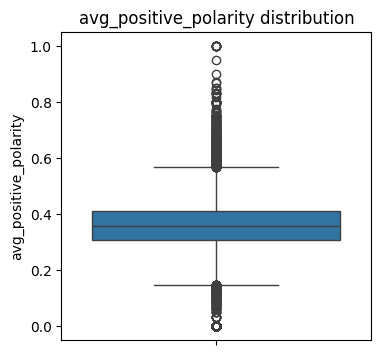

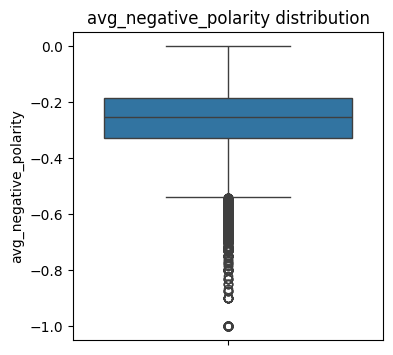

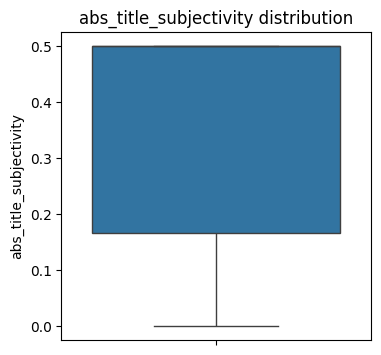

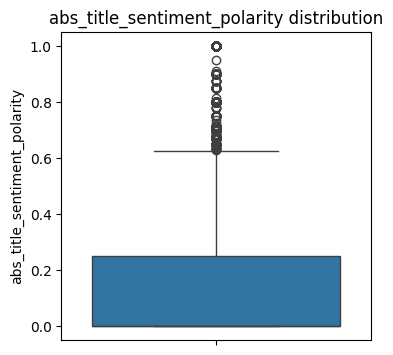

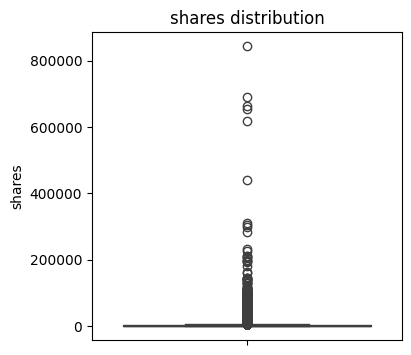

In [ ]:
for col in df_main_pair.columns:
    polt_dist(df_main_pair, col)

In [ ]:
# remove outliers
df_main_clean = df_main.query("n_unique_tokens < 1 and n_non_stop_words < 1 and num_hrefs < 101 and num_videos < 16 and num_imgs < 21 and average_token_length > 1")

A boxplot was created to illustrate the distribution of the shares. The distribution is right-skewed, with the majority of the data concentrated around the lower values, mostly between 100 and 10,000 shares. A small number of articles have much higher shares, as indicated by the long tail on the right. This shows that while most articles receive a moderate number of shares, a few outliers have a much higher number of shares, indicating significant variation in the data.

Outlier removal overview:
- n_unique_tokens and n_non_stop_words are rate variables and thefor must be between 0 and 1
- num_hrefs is typically below 100 for a standard article page, link counts above this are found on home pages
- num_video below 15, even 15 is generous, and its rare that video counts above this would be present in a standard article that does not soley focus on video aggregation
- num_img we expect to fall up to 20 images for visual heavy content, and likley skews more for longer content, but more than this is unresonable and will load slowly on a standard computer

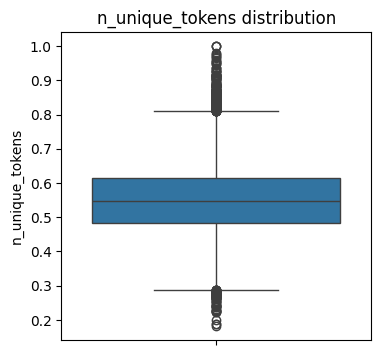

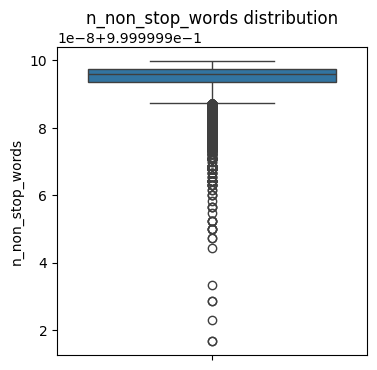

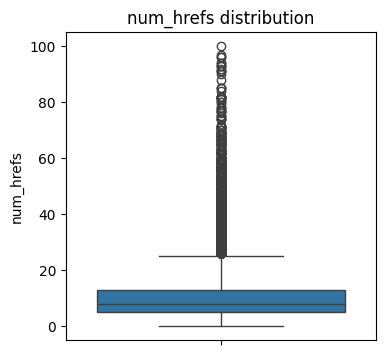

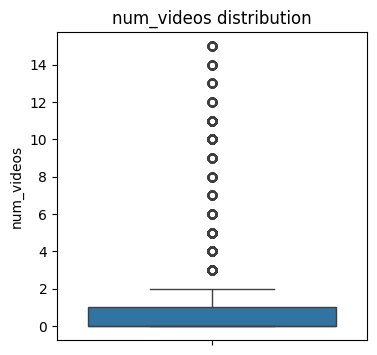

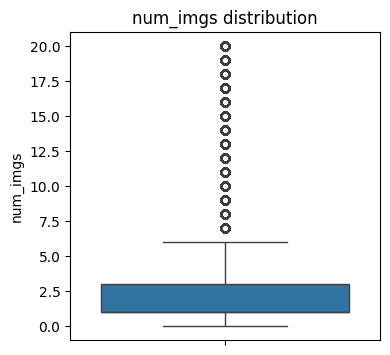

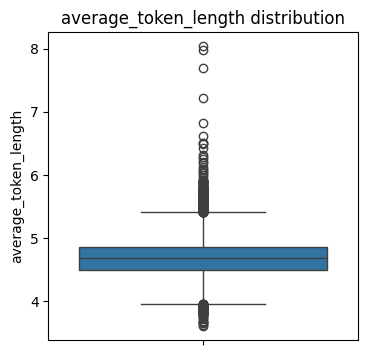

In [ ]:
# check df main
var_clean = ['n_unique_tokens', 'n_non_stop_words', 'num_hrefs', 'num_videos', 'num_imgs', 'average_token_length']

for col in var_clean:
    polt_dist(df_main_clean, col)

In [ ]:
df_col_clean = df_main_clean[df_col.columns]

In [ ]:
scaler = StandardScaler()
df_col_scaled = scaler.fit_transform(df_col_clean)
df_col_scaled = pd.DataFrame(df_col_scaled, columns=df_col.columns)

In [ ]:
corr_matrix_col = pd.DataFrame(df_col_scaled).corr()

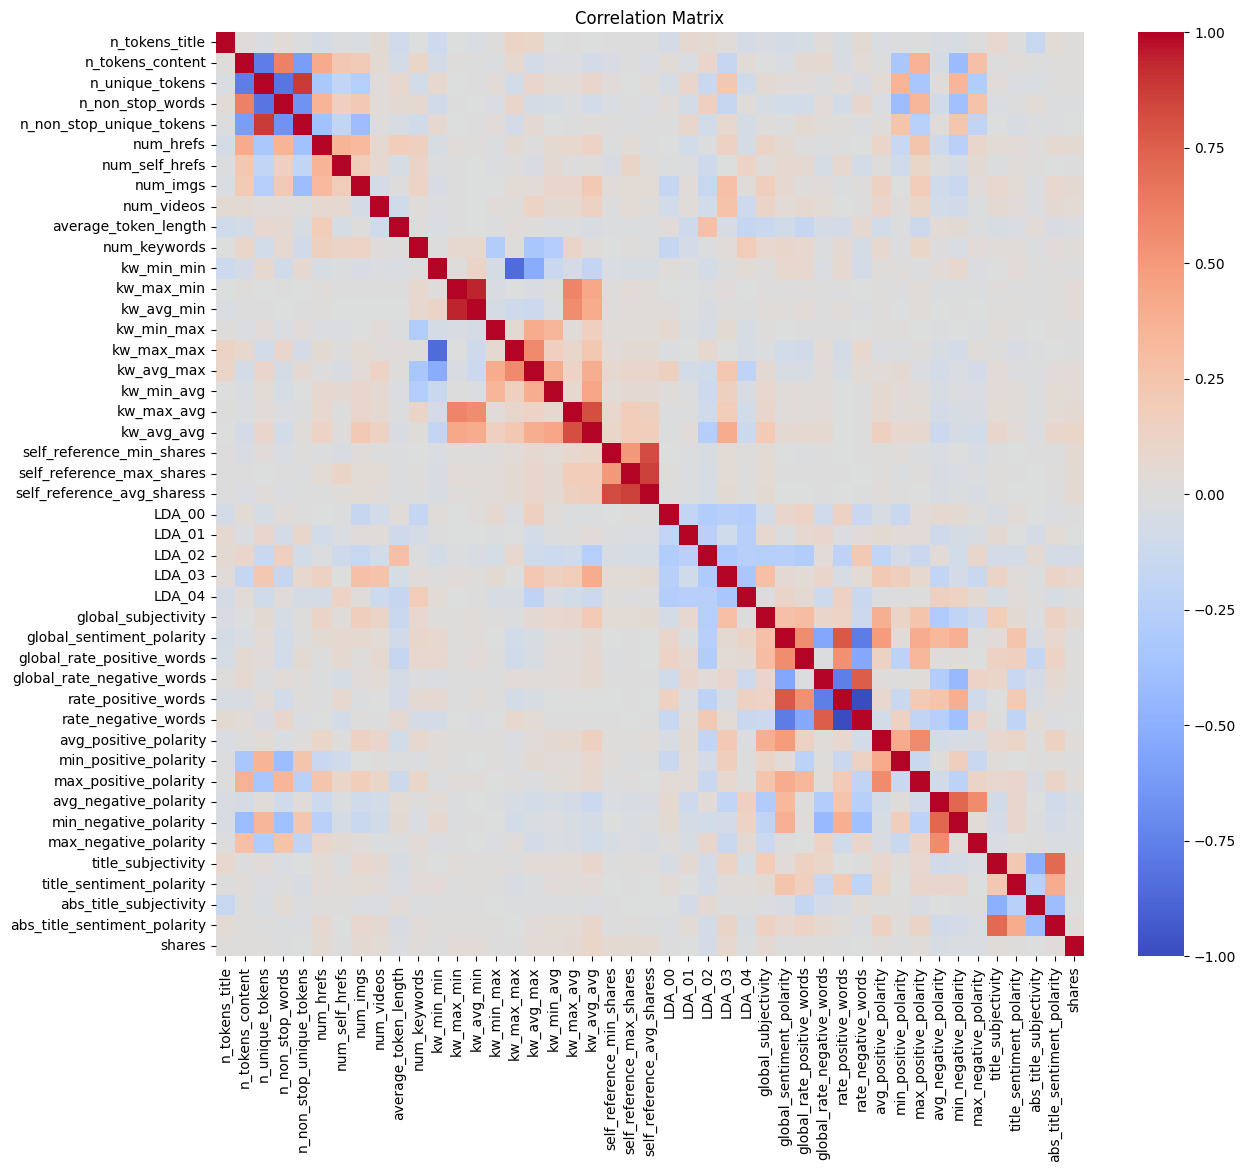

In [ ]:
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_col, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Outside of a few expected correlations between related variables (num_hrefs and num_self_hrefs) there are not many insights here, especially in terms of relation ship to total shares. However, best keyword average shares (kw_avg_avg) does seem to have the strongest correlation with shares. We will montior this through out the reminder of our analysis.

A few notes below:
- Positive correlation between number of links and number of words
- Positive correlation with number of images and words
These are likley due to the length of the article in general, but skew more subjective.

The highest correaltions for shares come from the following:
- number of links (hrefs)
- number of images / videos
- number of key words
- best keyword and LDA_3*
- Interesting articles with longer words seem to be more positive based on polarity
- Longer articles are more positive/less negative

There's an inverse relationship with the following:
- Average length of the words in the content

In [ ]:
df_genre = df_main_clean.iloc[:, 11:17]

In [ ]:
def onehot_clean_plot(df_col, col_map, name='Column', title='Distribution of Column Values', xlabel='Value', ylabel='Frequency', lim = None):
  # use idxmax to find the column with a '1' for each row
  df_col[name] = df_col[col_map.keys()].idxmax(axis=1)

  # replace column names with corresponding channel names
  df_col[name] = df_col[name].map(col_map)

  # drop the one-hot encoded columns if no longer needed
  df_col = df_col.drop(columns=col_map.keys())

  df_col['shares'] = df_main['shares']

  flierprops = dict(marker='o', markersize=2, linestyle='none', alpha=0.1)  # Set opacity to 0.3
  sns.boxplot(x=name, y='shares', data=df_col, flierprops=flierprops)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.ylim(lim)
  plt.show()


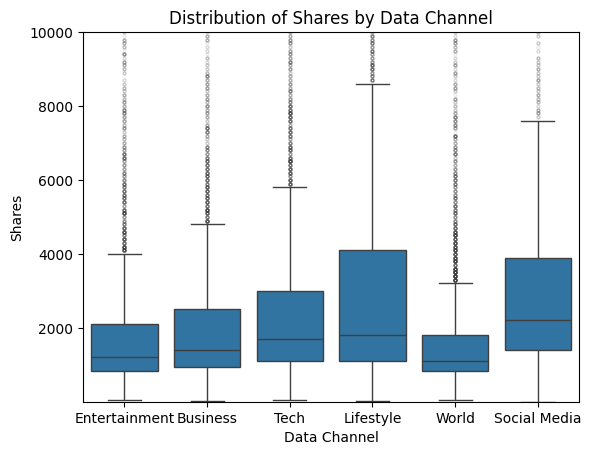

In [ ]:
channel_columns = {
    'data_channel_is_lifestyle': 'Lifestyle',
    'data_channel_is_entertainment': 'Entertainment',
    'data_channel_is_bus': 'Business',
    'data_channel_is_socmed': 'Social Media',
    'data_channel_is_tech': 'Tech',
    'data_channel_is_world': 'World'
}

onehot_clean_plot(df_genre, channel_columns, 'data_channel', 'Distribution of Shares by Data Channel', 'Data Channel', 'Shares', lim = (1, 10000))

Shares seems to perform consistently across article genre (data channel). World does seem to perform the least well and has the lowest variance, while Lifestyle and Social Media have the highest median and highest variance. We will keep an eye on this as we continue our analysis.

In [ ]:
day_columns = {
    'weekday_is_monday': 'Monday',
    'weekday_is_tuesday': 'Tuesday',
    'weekday_is_wednesday': 'Wednesday',
    'weekday_is_thursday': 'Thursday',
    'weekday_is_friday': 'Friday',
    'weekday_is_saturday': 'Saturday',
    'weekday_is_sunday': 'Sunday'
}

df_week = df_main_clean.iloc[:, 29:36]

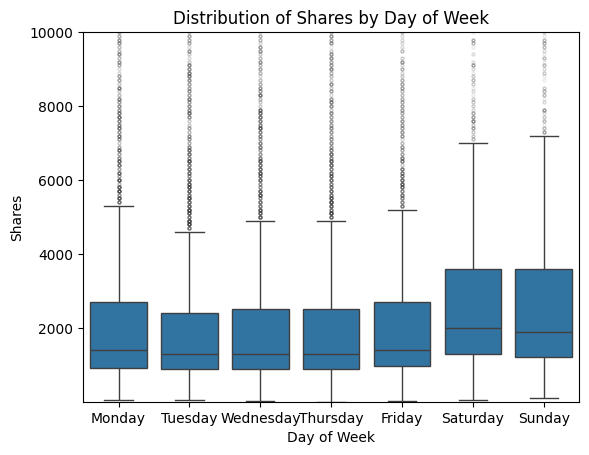

In [ ]:
onehot_clean_plot(df_week, day_columns, 'day_of_week', 'Distribution of Shares by Day of Week', 'Day of Week', 'Shares', lim = (1, 10000))

In [ ]:
df_shares_group = df_main_clean.copy()
df_shares_group["shares_bin"] = pd.qcut(df_shares_group["shares"], q=4, labels=False)

In [ ]:
def bin_dist(df, col, target, lim=None):
    flierprops = dict(marker='o', markersize=2, linestyle='none', alpha=0.1)
    plt.figure(figsize=(4, 4))
    sns.boxplot(x=col, y=target, data=df, flierprops=flierprops)
    plt.ylim(lim)
    plt.title(f"{target} distribution by {col}")
    plt.show()

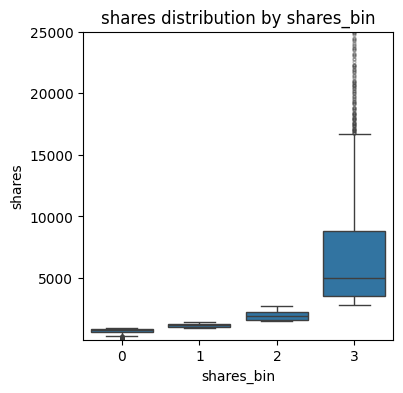

In [ ]:
bin_dist(df_shares_group, "shares_bin", "shares", lim = (1, 25000))

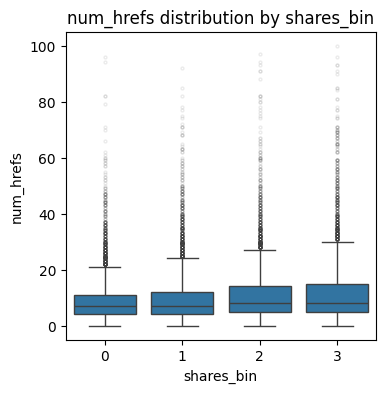

In [ ]:
bin_dist(df_shares_group, "shares_bin", "num_hrefs")

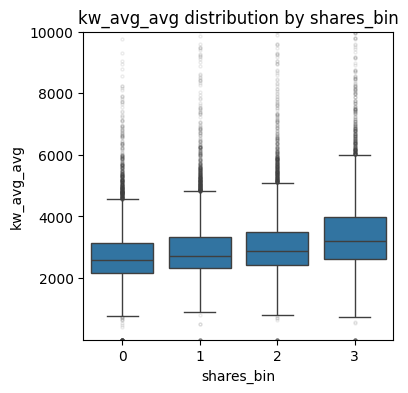

In [ ]:
bin_dist(df_shares_group, "shares_bin", "kw_avg_avg", lim = (1, 10000))

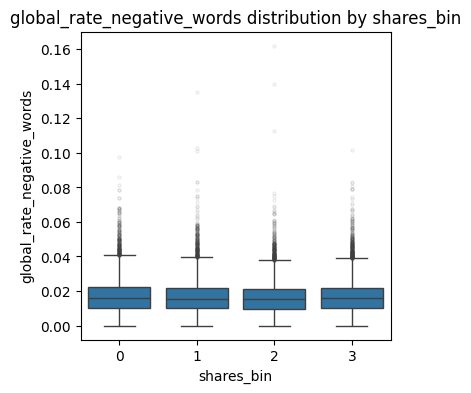

In [ ]:
bin_dist(df_shares_group, "shares_bin", "global_rate_negative_words")

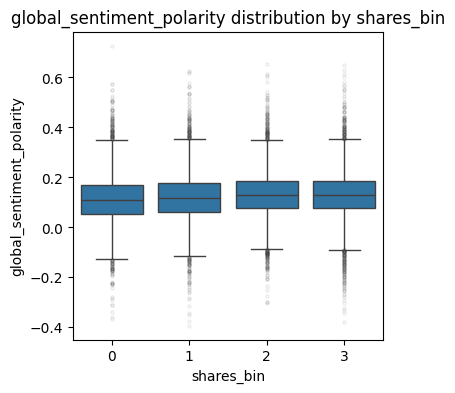

In [ ]:
bin_dist(df_shares_group, "shares_bin", "global_sentiment_polarity")

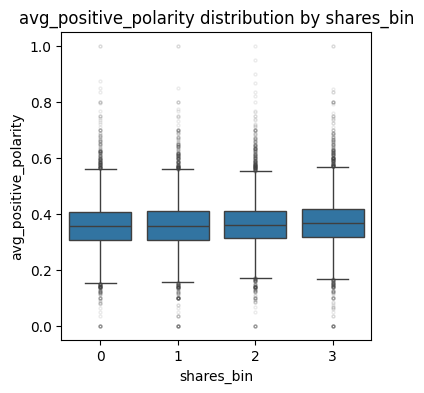

In [ ]:
bin_dist(df_shares_group, "shares_bin", "avg_positive_polarity")

## Data Splitting

In [ ]:
y = y.values.ravel()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Feature selection using SelectKBest to select the top 20 features
selector = SelectKBest(score_func=f_regression, k=20)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [ ]:
# Get the selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features)

Selected features: Index(['num_hrefs', 'num_imgs', 'num_videos', 'num_keywords',
       'data_channel_is_world', 'kw_max_min', 'kw_avg_min', 'kw_avg_max',
       'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'self_reference_avg_sharess', 'LDA_02',
       'LDA_03', 'global_subjectivity', 'avg_negative_polarity',
       'title_subjectivity', 'abs_title_sentiment_polarity'],
      dtype='object')


We split the dataset into training and testing sets, with 20% of the data allocated for testing and a fixed random state to ensure reproducibility. The features are then standardized using a standard scaler to make sure each feature has a mean of zero and a standard deviation of one. Then, the SelectKBest method is used to select the top 20 features based on their correlation with the target variable. This helps reduce the number of features in the dataset, which can improve model performance. The top 20 features were then outputted.

# Model building, tuning, and evaluation

## Support Vector Regression

In [ ]:
# Train the SVR model using the selected features
svr = SVR(kernel='rbf')
svr.fit(X_train_selected, y_train)

SVR()

In [ ]:
# Evaluate the model
y_pred = svr.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 2360.595171659745
Root Mean Squared Error (RMSE): 11125.137138187578


A support vector regression (SVR) model was trained using the selected features from the previous steps. The SVR model is created using the RBF kernel, which is useful for non-linear regression tasks. The model is trained on the selected training features and target variable to find patterns and relationships in the data.

The model was then evaluated by predicting the test set values. The mean absolute error and root mean squared error are calculated to assess the model’s performance. The MAE produced a value of 2,360.6, meaning that the model's predictions differ from the actual values by 2360 shares. The RMSE produced a value of 11,125.14, indicating that the model's larger prediction errors are substantial and have a strong influence on the overall error, suggesting the presence of some significant differences in predictions.

In [ ]:
# Use sampling for computational efficiency
X_test_sample = X_test_selected[:1000]
y_test_sample = y_test[:1000]

# Calculate permutation importance
result = permutation_importance(svr, X_test_sample, y_test_sample, n_repeats=5, random_state=42)

We used a sample of 1,000 test records to speed up the process of calculating the permutation importance. This method helps to identify the importance of each feature by evaluating how performance changes when a feature's values are randomly shuffled. By repeating the process multiple times, the permutation importance is calculated, allowing an understanding of which features contribute most to the model's performance.

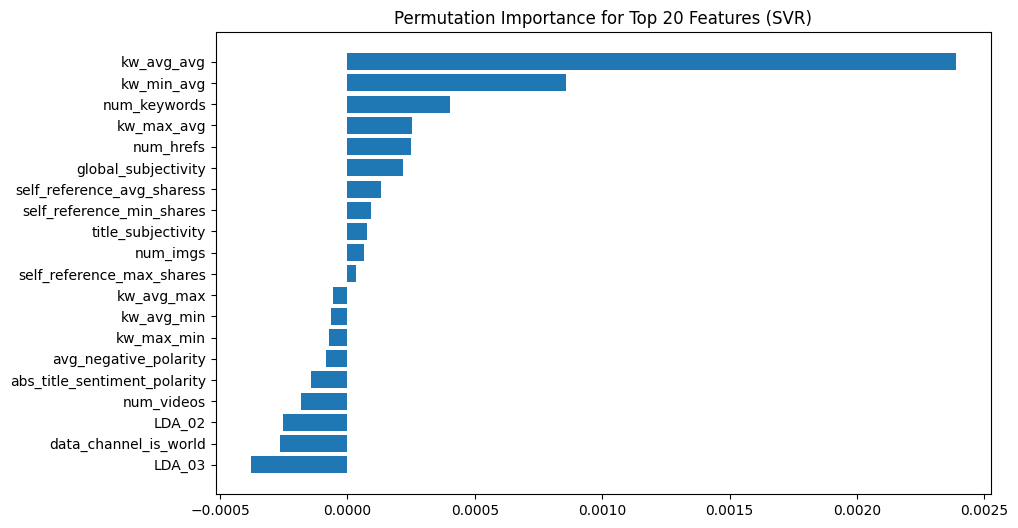

In [ ]:
# Visualize feature importance
feature_importance = result.importances_mean
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), selected_features[sorted_idx])
plt.title("Permutation Importance for Top 20 Features (SVR)")
plt.show()

This bar chart displays the permutation importance of the top 20 features in the SVR model. The most influential feature is the average of keyword averages, followed by the minimum average of keywords and the number of keywords as a whole. This shows that keyword-related features play a significant role in the model’s predictions. Other notable variables include the number of hrefs and global subjectivity. The chart helps focus attention on the key features driving the model's performance.

## Random Forest Regressor

In [ ]:
y_rf = df_main_clean['shares']
X_rf = df_main_clean.drop('shares', axis=1)

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

In [ ]:
# remove related variables / keep avg or base level of engineered variables
drop_var = [
    "n_non_stop_unique_tokens",
    "num_self_hrefs",
    "kw_min_min",  # keep average shares from average kw
    "kw_max_min",
    "kw_min_max",
    "kw_max_max",
    "kw_min_avg",
    "kw_max_avg",
    "self_reference_min_shares",
    "self_reference_max_shares",
    "global_rate_positive_words",
    "global_rate_negative_words",
    "rate_positive_words",
    "rate_negative_words",
    "min_positive_polarity",
    "max_positive_polarity",
    "min_negative_polarity",
    "max_negative_polarity",
    "title_subjectivity",
    "title_sentiment_polarity",
    "weekday_is_monday",
    "weekday_is_tuesday",
    "weekday_is_wednesday",
    "weekday_is_thursday",
    "weekday_is_friday",
    "weekday_is_saturday",
    "weekday_is_sunday",
]

X_train_rf = X_train_rf.drop(drop_var, axis=1)
X_test_rf = X_test_rf.drop(drop_var, axis=1)

In [ ]:
y_train_log_rf = np.log1p(y_train_rf)

In [ ]:
X_train_rf.columns

Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_avg_min', 'kw_avg_max', 'kw_avg_avg',
       'self_reference_avg_sharess', 'is_weekend', 'LDA_00', 'LDA_01',
       'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'avg_positive_polarity',
       'avg_negative_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity'],
      dtype='object')

In [ ]:
rf = RandomForestRegressor(random_state=1)

param_grid = {
    "n_estimators": [100, 200],  # try 200 and 300 trees
    "max_depth": [10, 20, 30],  # try depths of 10, 20, and 30
    "max_features": [
        "sqrt",
        "log2",
    ],  # try square root and log2 of the number of features
}

grid_search = RandomizedSearchCV(
    rf,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2,
)

grid_search.fit(X_train_rf, y_train_log_rf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [100, 200]},
                   scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 20}


In [ ]:
best_rf = grid_search.best_estimator_

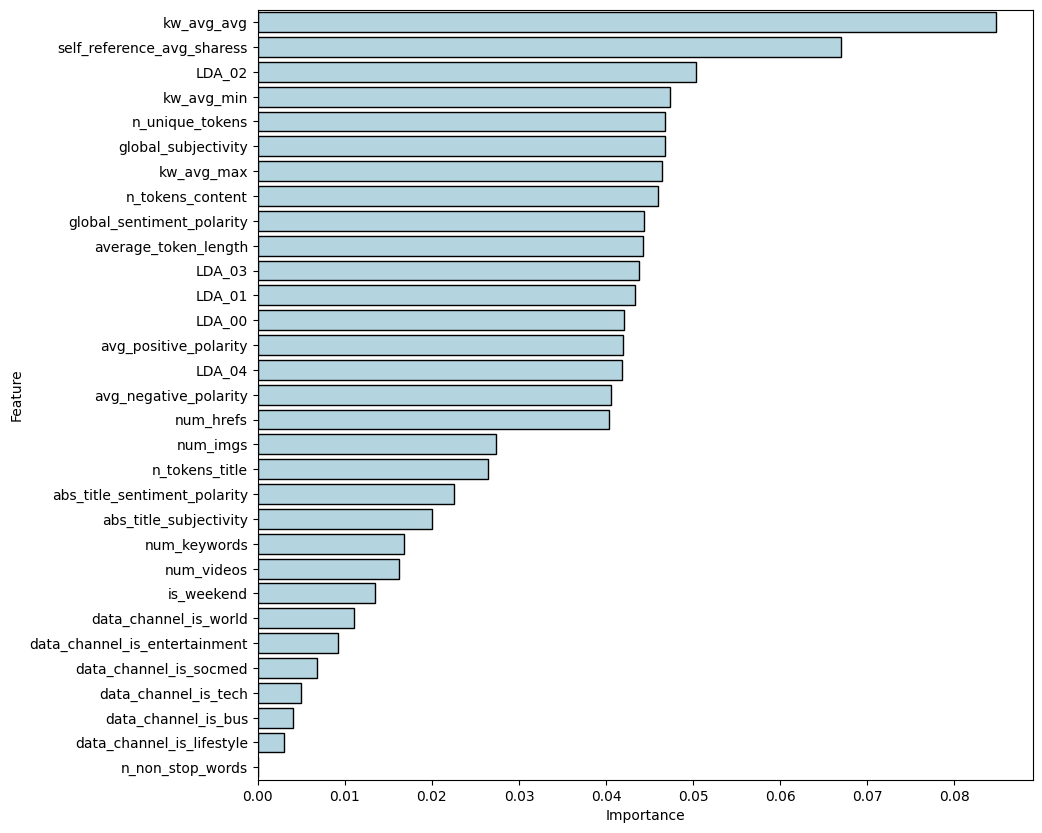

In [ ]:
# plot feature importance with error
importances = best_rf.feature_importances_
df = pd.DataFrame({'Feature': X_train_rf.columns, 'Importance': importances})
df = df.sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=df, color='lightblue', edgecolor='black');

In [ ]:
y_pred_log_rf = best_rf.predict(X_test_rf)
y_pred_rf = np.expm1(y_pred_log_rf)

mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")

Mean Absolute Error (MAE): 2458.3041401243504
Root Mean Squared Error (RMSE): 14175.75601928701


## XGboost Regressor

In [ ]:
XGB_model = XGBRegressor()

params = {
    'max_depth': np.arange(0, 10),
    'learning_rate': [0.01, 0.1, 0.8],
    'n_estimators': np.arange(100, 500),
    'booster': ['gbtree'],
    'tree_method': ['gpu_hist'],
    'min_child_weight': np.arange(1, 5),
    'eval_metric': ['mae', 'rmse'],
    'gamma': [0, 1, 10, 100, 1000],
    'subsample': np.arange(0.2, .8),
    'colsample_bytree':  np.arange(0.2, .8),
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

xgb_grid = RandomizedSearchCV(XGB_model, param_distributions=params, n_iter=10,cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
       438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
       451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463,
       464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476,
       477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 497, 498, 499]),
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [0, 0.1, 1],
                                        'subsample': array([0.2]),
                                        'tree_method': ['gpu_hist']},
                   scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
print("Best XGBooost parameters:", '\n' ,xgb_grid.best_params_)

Best XGBooost parameters: 
 {'tree_method': 'gpu_hist', 'subsample': 0.2, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 151, 'min_child_weight': 4, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 10, 'eval_metric': 'rmse', 'colsample_bytree': 0.2, 'booster': 'gbtree'}


<Axes: title={'center': 'Top 15 features used by the XGBoost model'}, xlabel='Importance', ylabel='Feature'>

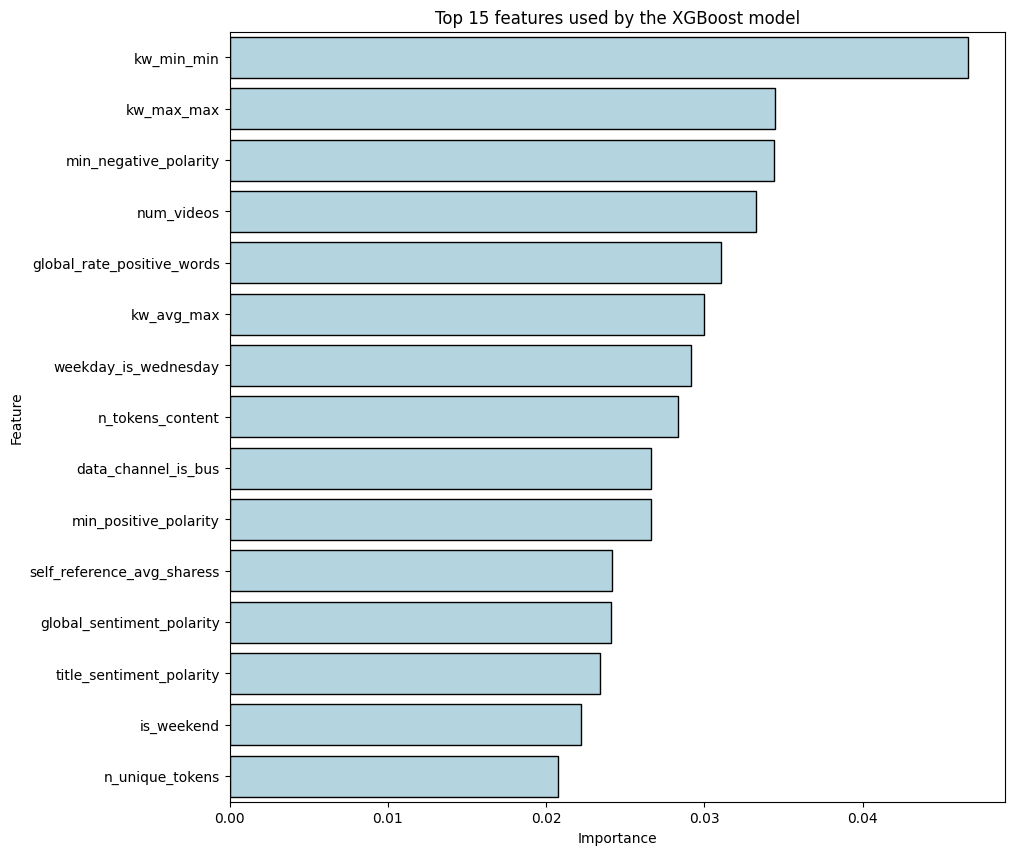

In [ ]:
best_xgb = xgb_grid.best_estimator_

feature_importance = best_xgb.feature_importances_
xgb_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
xgb_df = xgb_df.sort_values(by='Importance', ascending=False, ).head(15)
plt.figure(figsize=(10, 10))
plt.title('Top 15 features used by the XGBoost model')
sns.barplot(x='Importance', y='Feature', data=xgb_df, color='lightblue', edgecolor='black')

In [ ]:
params = {'tree_method': 'gpu_hist',
          'subsample': 0.2,
          'reg_lambda': 1,
          'reg_alpha': 0.1,
          'n_estimators': 150,
          'min_child_weight': 5,
          'max_depth': 6,
          'learning_rate': 0.01,
          'gamma': 10,
          'eval_metric': 'rmse',
          'colsample_bytree': 0.2,
          'booster': 'gbtree'}

xgb = XGBRegressor(**params)

xgb.fit(X_train, y_train)
y_preds = xgb.predict(X_test)

def get_metrics(y_test, y_preds):
    mae = mean_absolute_error(y_test, y_preds)
    mse = mean_squared_error(y_test, y_preds)
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))


    print('Evaluation Metrics:')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')

get_metrics(y_test, y_preds)

Evaluation Metrics:
Mean Absolute Error (MAE): 3007.32553288795
Mean Squared Error (MSE): 117647280.43275301
Root Mean Squared Error (RMSE): 10846.533106608444


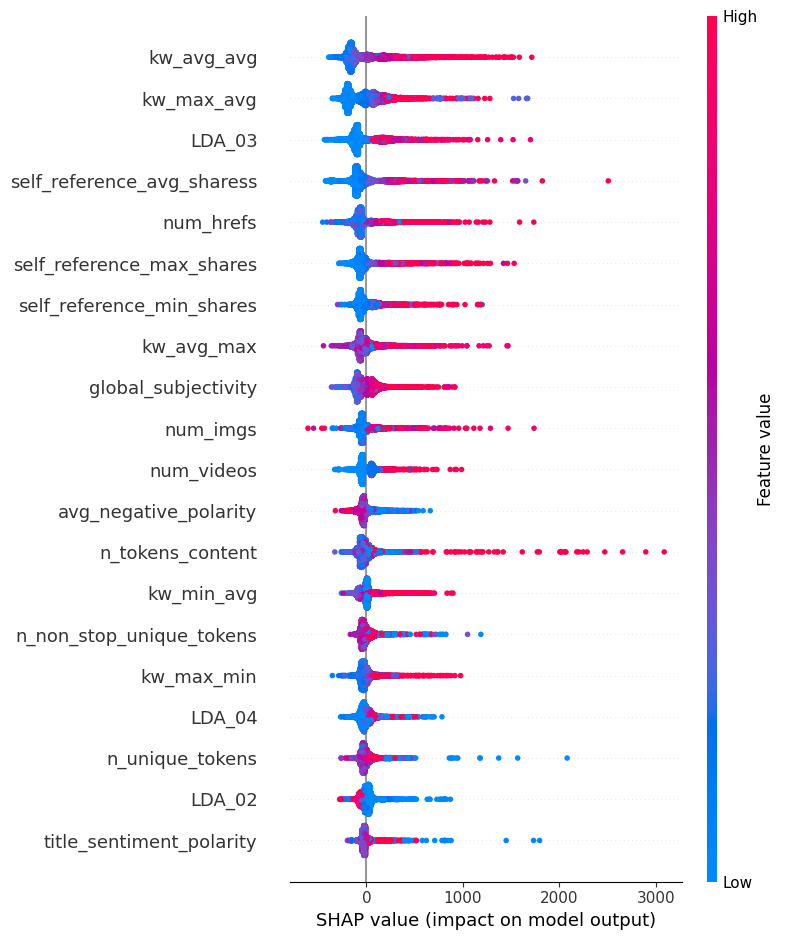

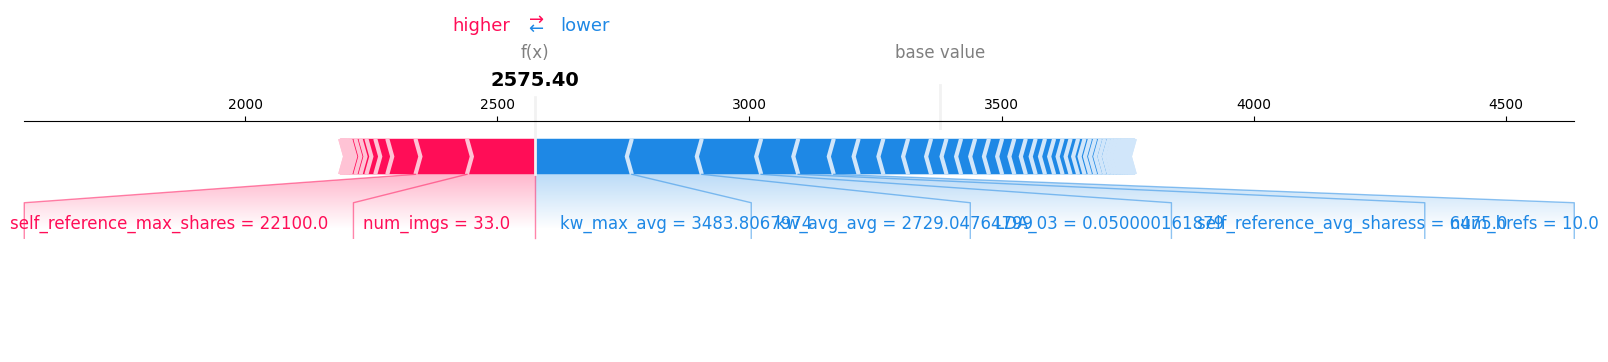

In [ ]:
""""Below is a waterfall plot of the shap values for the xgboost model.
The feature importance plot aligns more with the other model feature importance plots"""


explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
shap_values_row = explainer(X_test.iloc[[0]])
shap.force_plot(shap_values_row.base_values[0], shap_values_row.values[0], X_test.iloc[0], matplotlib=True)

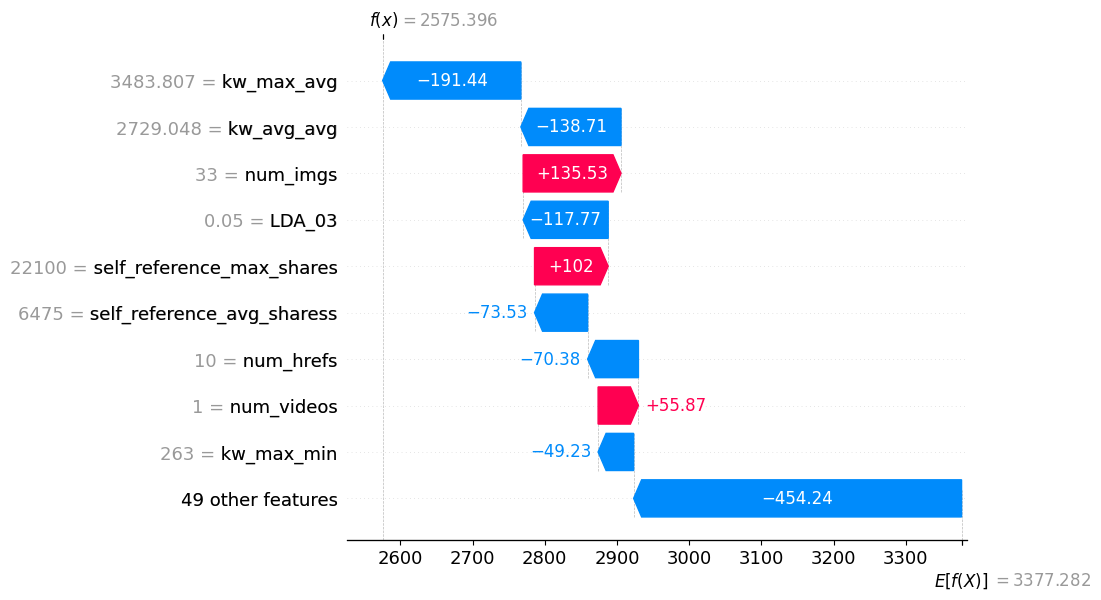

In [ ]:
shap.plots.waterfall(shap_values[0])

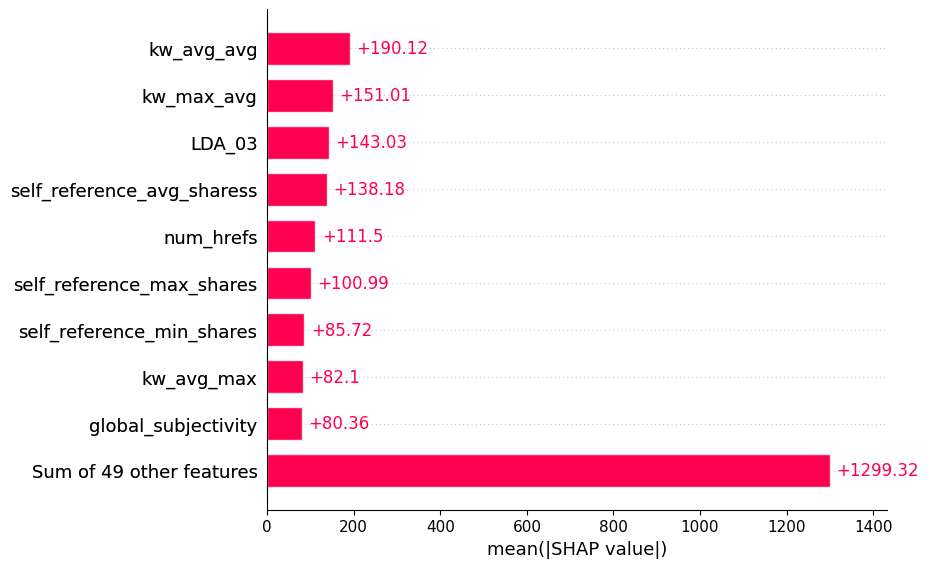

In [ ]:
shap.plots.bar(shap_values)